**SOW-MKI49: Neural Information Processing Systems**  
*Weeks 4 and 5: Assignment (225 points + 30 bonus points)*  
Author: Umut

Group number: 25  
Felicity Reddel, s4830717  
Max Reddel, s4830709  
Johan van den Heuvel, s4770528

In [1]:
from chainer import ChainList, optimizers, serializers
import chainer
import chainer.functions as F
import chainer.links as L
import numpy as np

import sys

In [2]:
# import sys
# sys.path
# print(sys.path) 
# sys.path.append('../midi')

# import midi
# from midi import utils

**WaveNet component (75 points)**

* Implement missing parts of the call method (y and z). **25 points**
* Implement residual block class. **50 points**

---
Reminder:

* One convolution layer that has 61 kernels of size 2 with no nonlinearities.

![alt text](http://i67.tinypic.com/21mgi2w.png)
![alt text](http://i67.tinypic.com/292n04y.png)
---



In [3]:
class _WaveNet(ChainList):
    def __init__(self):
        links = (L.Convolution2D(61, 61, (1, 2)),) 
        links += tuple(_ResidualBlock((1, 2 ** (i % 6))) for i in range(6)) # T6 layers
        links += (L.Convolution2D(512, 512, 1), L.Convolution2D(512, 3843, 1)) # 1 and 2 layers

        super(_WaveNet, self).__init__(*links)
        

    def __call__(self, x):
#         print('WaveNet call')
        y = self[0](F.pad(x, ((0, 0), (0, 0), (0, 0), (1, 0)), 'constant')) # The output of this layer becomes the input of the next layer
        z = 0

        for i in range(1, len(self) - 2):
        #TODO    
            skip_x, res_x = self[i](y)
            y = res_x
            z += skip_x
            
        
        h = F.relu(z)
        h = self[len(self)-2](h)
        h = F.relu(h)
        h = self[len(self)-1](h)
    
        
        z, y = F.split_axis(h, (2*61,), 1)
        
#         print('WaveNet done')

        return F.reshape(y, (y.shape[0], 61, 61, y.shape[3])), \
               F.reshape(z, (z.shape[0], 2, 61, z.shape[3]))

class _ResidualBlock(ChainList):    
    def __init__(self, dilationFactor): # what parameter is this

        links = (L.DilatedConvolution2D(None, 122, (1,1), dilate=dilationFactor),)
        links += (L.Convolution2D(None, 512 + 61,(1,1)),)
        
        super(_ResidualBlock, self).__init__(*links)
        
    def __call__(self, x):
#         print('Residual call')
        saved_x = x
        
        h = self[0](x)
        h = F.split_axis(h, 2, 1)       
        x = F.tanh(h[0]) * F.sigmoid(h[1])
        
        res_x, skip_x = F.split_axis(self[1](x), (61,), 1)
        
        res_x += saved_x
        
#         print('Residual done')
        
        return skip_x, res_x

**CRF-RNN component (50 points)**

* Implement missing parts of the call method (z). **25 points**
* Why is z not normalized in the last iteration? **25 points**

---

Reminder:

![alt text](http://i68.tinypic.com/sy6mix.png)

---

In [4]:
class _CRF(ChainList):
    def __init__(self):
        super(_CRF, self).__init__(L.ConvolutionND(1, 2, 2, 1, nobias = True))

    def __call__(self, x, y):
        #TODO
#         print('CRF call')
        z = y
#         print(x.shape)
#         print(y.shape)

        for i in range(5):
#             print(i)
            # multiply N*61*61 by N*2*61 and result is N*2*61
            # so should be 2*61 X 61*61 or 61*61 X (2*61)T
#             print(type(z), ' ', type(x))
            shape = z.shape
            x = F.reshape(x, (-1, 61, 61)) # copied from forum
            z = F.reshape(z, (-1, 2, 61))
            z = F.matmul(z,x) # message passing layer 
            
            
#             print(z.shape)
            z = self[0](z) #comp
            z = F.reshape(z, shape) # fit the y shape again
            z = - y - z # local update and norm

            if i < 4:
                z = F.softmax(z)

#         print('CRF done')        
                
        return z

# Why not normalizing z in last iteration?

- Softmax -> probabilities (add up to 1)
- What we want with Q, the mean field approximation: selecting a tone by choosing the highest value in Q. Normalizing the values would not change which one is the highest value. Thus, it is not necessary to normalize the values.

### Sidenote: 'Why we want to normalize in all previous iterations:'  
- In iterations 0-4, we want to feed back the current approximation (z). 
- In each iteration, we multiply the current approximation with x (= k = the pairwise output of the WaveNet component). 
- If the values in x are either very big or very small, naively multiplying the current approximation and later subtracting psi, could result in a "vanishing z". 
- This could potentially also lead to weird things as the subtraction of psi could result in negative values. These negative values would in the next iteration be multiplied with x. Then, bigger values in x would to This might even become negative and hence could randomly bounce around zero in the next rounds?)

**WaveCRF model (50 points)**

1. Implement missing parts of the call method (k, psi_u and Q_hat). **20 points**
2. Implement missing parts of the save and load methods (save and load model). **10 points**
3. Implement missing parts of the test and train methods (forward and/or backward propagate). **20 points**

In [5]:
class WaveCRF(object):
    def __init__(self):
        self.log = {('test', 'accuracy'): (), ('test', 'loss'): (), ('training', 'accuracy'): (),
                    ('training', 'loss'): ()}
        self.model = ChainList(_WaveNet(), _CRF())
        self.optimizer = optimizers.Adam(0.0002, 0.5)

        self.optimizer.setup(self.model)

    def __call__(self, x):
        #TODO
        k, psi_u = self.model[0](x) # _WaveNet outputs k and psi
        Q_hat = self.model[1](k, psi_u) # _CRF outputs Q?
        print(Q_hat.shape)

        return F.transpose(F.reshape(Q_hat, (x.shape[0], x.shape[3], 2, 61)), (0, 2, 3, 1))

    @classmethod
    def load(cls, directory):
        self = cls()
        self.log = np.load('{}/log.npy'.format(directory))

        #TODO
        serializers.load_npz('{:s}/model.npz'.format(directory), self.model) # Load model
        serializers.load_npz('{}/optimizer.npz'.format(directory), self.optimizer)

        return self

    def save(self, directory):
        np.save('{}/log.npy'.format(directory), self.log)
        
        #TODO
        serializers.save_npz('{:s}/model.npz'.format(directory), self.model) # Save model
        serializers.save_npz('{}/optimizer.npz'.format(directory), self.optimizer)

    def test(self, Q, x):
        with chainer.using_config('train', False):
            #TODO
            a,b = self.model.__getitem__(0)(x) # Forward prop
            Q_hat = self.model.__getitem__(1)(a,b)
            loss = F.softmax_cross_entropy(Q_hat, Q)# Forward prop

            self.log['test', 'accuracy'] += (float(F.accuracy(Q_hat, Q).data),)
            self.log['test', 'loss'] += (float(loss.data),)

    def train(self, Q, x):
        #TODO
        # fix wacky hack
#         print(self.model.__getitem__(0).__call__(x)) # This line removes error for call
#         print(help(ChainList))

        a,b = self.model.__getitem__(0)(x) # Forward prop
        Q_hat = self.model.__getitem__(1)(a,b)
        loss = F.softmax_cross_entropy(Q_hat, Q)# Forward prop
#         print("loss: ", loss)

        #TODO
        self.model.cleargrads() # Backprop
        loss.backward() # Backprop
        self.optimizer.update() # Backprop

        self.log['training', 'accuracy'] += (float(F.accuracy(Q_hat, Q).data),)
        self.log['training', 'loss'] += (float(loss.data),)

In [6]:
%matplotlib inline

import IPython
import chainer
import matplotlib
import numpy
import os
import pickle
import random
import tqdm

In [7]:
import pickle
import numpy
root = '..'
with open('{}/Assignment2/piano_rolls.p'.format(root), 'rb') as f:
    piano_rolls = pickle.load(f)

In [8]:
batch_size = 30
epochs = 50
root = '..'

In [9]:
with open('{}/Assignment2/piano_rolls.p'.format(root), 'rb') as f:
    piano_rolls = pickle.load(f)

keys = sorted(piano_rolls.keys())

random.seed(6)
random.shuffle(keys)

test_set = dict((key, piano_rolls[key]) for key in keys[:int(0.1 * len(keys))])
training_set = dict((key, piano_rolls[key]) for key in keys[int(0.1 * len(keys)):])
training_set_keys = list(training_set.keys())

In [10]:
waveCRF = WaveCRF()

waveCRF.model.to_gpu()

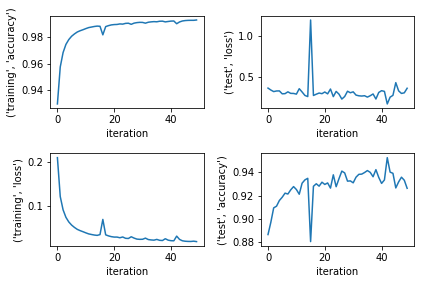

In [11]:
for epoch in tqdm.tnrange(epochs):
    random.shuffle(training_set_keys)

    batch = ()

    for key in tqdm.tqdm_notebook(training_set_keys, leave = False):
        i = random.randint(0, training_set[key].shape[1] - 80)
        batch += (training_set[key][32 : 93, i : i + 80],)

        if len(batch) == batch_size:
            batch = waveCRF.model.xp.array(batch)
#             print(batch.shape)
            waveCRF.train(batch[:, :, 1:].astype('i'), batch[:, :, None, :-1].astype('f'))

            batch = ()

    for key in tqdm.tqdm_notebook(test_set, leave = False):
        batch = waveCRF.model.xp.array((test_set[key][32 : 93],))
#         print(batch.shape)
        waveCRF.test(batch[:, :, 1:].astype('i'), batch[:, :, None, :-1].astype('f'))

    IPython.display.clear_output()

    for i, key in enumerate(waveCRF.log):
        matplotlib.pyplot.subplot(221 + i)
        matplotlib.pyplot.plot(numpy.array(waveCRF.log[key]).reshape(epoch + 1, -1).mean(1))
        matplotlib.pyplot.xlabel('iteration')
        matplotlib.pyplot.ylabel(key)

    matplotlib.pyplot.tight_layout()
    matplotlib.pyplot.show()
    os.makedirs('{}/Models/WaveCRF/{}'.format(root, epoch))
    waveCRF.save('{}/Models/WaveCRF/{}'.format(root, epoch))

**Test (50 points)**  

* Generate a number of samples, pick the best one and play it in the notebook. **50 points**

In [12]:
#TODO
# Test
# WaveCRF.load('Models/{}'.format(99))
# batch = waveCRF.model.xp.array((test_set['006606B_/1_0_7_0'][32 : 93],))
# print(batch.shape)
# output = waveCRF(batch[:, :, None, :-1].astype('f'))
# normalized_output = F.softmax(output)

In [13]:
# piano_roll = np.random.rand(61, 79) < .5 # let's randomly generate some piano roll with 61 notes and 79 time points
# x = np.random.rand(1, 61, 2) < .5
# y = waveCRF(x[:, :, None, :-1].astype('f'))
# print(x.shape)
# print(y.shape)
# # waveCRF(piano_roll[:, :, None, :-1].astype('f'))
# x = utils.midiwrite('piano_roll.mid', piano_roll.T, (32, 93), 0.25) # 3rd arg is the start and end notes; 4rth arg is time between samples


**Bonus question (30 points)**

* Discuss how you can improve the model (you can talk about different architectures or different ways to encode the inputs, etc.) **10 points**
* Discuss the assumptions behind the meanfield approximation and its shortcomings. **10 points**
* Prove that the iterative update equation (CRF-RNN component) is differentiable so that we can backpropagate through them. **10 points**

## Model improvement suggestions

We are surprised by the generated piano-rolls. They are all (almost) identical, start with many different parallel tones and over time, they seem to just decrease in volume. Probably some thing(s) went wrong but we couldn’t find yet what that is. Thus, from listening it seems like we didn’t gain much information on what might be improved about the network specifics.

Generally, we could tackle different aspects:

[Overfitting]
Our model seems to overfit very quickly (after approximately 5 epochs already). We could try to apply different regularization techniques (e.g. dropout, L1 or L2).

[‘Memory span’]
If the produced piano roll doesn’t sound coherent over time, we could try to increase the ‘memory span’ of the network. This could be done either by increasing T (the amount of previous tones that are taken into account to predict the next note), by adapting the network architecture (e.g. increasing the number of residual blocks that we use or by potentially making use of other memory possibilities that are usually used in recurrent networks (LSTM, GRU cells and the like).

[Decreasing volume over time]
Maybe we could use normalization to avoid the decrease in volume over time. Or we could have each tone at the same volume.

[Monophonic]
Apparently, the quality of being monophonic was not learned. Maybe we could set restrictions in order to achieve that.


## Mean Field Approximation – Assumptions and Shortcomings

It follows from $Eq. 1$ (see below) that main assumption of the mean field approximation is that each individual $Q_i(x_i^{(t)})$ is independent from the other $Q_i(x_i^{(t)})$'s. (Otherwise, we could not just factorize the separate the $Q_i(x_i^{(t)})$'s.) We do this, to make the calculations tractable.

$Eq. 1$:
$$Q(x^{(t)}| x^{(t-T)}, ... , x^{(t-1)}) = \prod_{i \in V}  Q_i(x_i^{(t)})$$


However, this assumption is also a shortcoming as the different $Q_i(x_i^{(t)})$'s are clearly not totally independent from each other. If they would be, conditional random fields would not look like the first picture below but more like the second picture below.


<img src=http://i65.tinypic.com/23t17kl.jpg width="250">

<img src=http://i67.tinypic.com/537jo8.jpg width="250">



## Proof: iterative update equation is differentiable